<a href="https://colab.research.google.com/github/take2rohit/denoising_autoencoder/blob/master/22_cleaned_resnet_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!git clone https://github.com/ruphan/OrigamiDataset
# !git clone https://github.com/take2rohit/denoising_autoencoder.git 
# !cp -rf denoising_autoencoder/DAE_dataset_helper.py .
# !rm -rf denoising_autoencoder

fatal: destination path 'OrigamiDataset' already exists and is not an empty directory.


In [1]:
# get helper files and dataset
#importing the necessary packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import os
import json
from itertools import combinations
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# From custom helper
# from DAE_dataset_helper import OrigamiDatasetGenerate,ValidationGenerate
# from DAE_dataset_helper import ToTensor,Resize, Normalize,AddNoise,RandomBackground
# from DAE_dataset_helper import ToTensorValidate,NormalizeValidate,ResizeValidate

# Dataset Loading, Visualising and Architecture design 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import numpy as np,os

class AddNoise(object):
    def __init__(self, mean, var, noise_typ = "gauss"):
        self.noise_typ = noise_typ
        self.mean = mean 
        self.var = var
    
    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']

        if self.noise_typ == "gauss":
            row,col,ch= augmented.shape
            mean = self.mean
            var = self.var
            sigma = var**0.5
            gauss = np.random.normal(mean,sigma,(row,col,ch))
            gauss = gauss.reshape(row,col,ch)
            noisy = noisy = np.clip(augmented + gauss, 0,1)

        if self.noise_typ == "s&p":
            row,col,ch = augmented.shape
            s_vs_p = self.mean
            amount = self.var
            out = np.copy(augmented)
            # Salt mode
            num_salt = np.ceil(amount * augmented.size * s_vs_p)
            coords = [np.random.randint(0, i - 1, int(num_salt))
                    for i in augmented.shape]
            out[coords] = 255

            # Pepper mode
            num_pepper = np.ceil(amount* augmented.size * (1. - s_vs_p))
            coords = [np.random.randint(0, i - 1, int(num_pepper))
                    for i in augmented.shape]
            out[coords] = 0
            noisy = out
        
        return {'original': original,
                'augmented': noisy,
                'dof_vec' : sample['dof_vec']}    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        original = np.transpose(original, (2, 0, 1))
        augmented = np.transpose(augmented, (2, 0, 1))
        return {'original': torch.from_numpy(original).float(),
                'augmented': torch.from_numpy(augmented).float(),
                'dof_vec' : torch.from_numpy(sample['dof_vec']).float()}

class Resize(object):
    """ndarrays resize."""
    
    def __init__(self, size):
        self.size = size
        
    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        
        original = cv2.resize(original, dsize=self.size, interpolation=cv2.INTER_CUBIC)
        original = np.expand_dims(original, axis=2)

        augmented = cv2.resize(augmented, dsize=self.size, interpolation=cv2.INTER_CUBIC)

        return {'original': original, 
                'augmented':augmented,
                'dof_vec' : sample['dof_vec'] }

class RandBrightness(object):
    """add random brightness."""    
       
    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        
        augmented = augmented * np.random.uniform(0.2,1.8)
        augmented = np.clip(augmented,0,1)

        return {'original': original, 
                'augmented':augmented, 
                'dof_vec' : sample['dof_vec']}

class Normalize(object):
    
    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        
        min_noisy,max_noisy = np.min(original),np.max(original)
        original = (original - min_noisy)/(max_noisy-min_noisy)
        
        min_noisy,max_noisy = np.min(augmented),np.max(augmented)
        augmented = (augmented - min_noisy)/(max_noisy-min_noisy)
        return {'original': original, 
                'augmented':augmented,
                'dof_vec' : sample['dof_vec'] }

In [5]:
class DataLoadResUnet(Dataset):
    '''
    Change self.dataset_size to set custom dataset size for testing
    '''
    def __init__(self, origami_dir, bg_dir, csv_dir, dataset_size=150,transform=None):
        self.bg_dir = bg_dir
        self.origami_dir = origami_dir
        self.transform = transform
        self.dataset_size=dataset_size
        self.dframe = pd.read_csv(csv_dir)
        
        self.orgami_list = [f for f in os.listdir(self.origami_dir) \
         if os.path.isfile(os.path.join(self.origami_dir, f))]
        
        # self.dataset_size=1000
        self.dataset_size = len(self.orgami_list)

        self.bg_list = [f for f in os.listdir(self.bg_dir) \
         if os.path.isfile(os.path.join(self.bg_dir, f))]
    def merge(self,origami_loc, background_loc):
        origami = cv2.imread(origami_loc)
        origami_black_bg = origami.copy()
        background = cv2.imread(background_loc)
        background = cv2.resize(background, dsize=(origami.shape[0],origami.shape[1]), 
                                interpolation=cv2.INTER_CUBIC)
        frame_threshold = cv2.inRange(cv2.cvtColor(origami, cv2.COLOR_BGR2HSV), (50, 50, 50), (70, 255, 255))
        temp1 = cv2.bitwise_and(origami_black_bg, origami_black_bg, mask=cv2.bitwise_not(frame_threshold))
        temp2 = cv2.bitwise_and(background, background, mask=frame_threshold)
        out_image = cv2.bitwise_not(frame_threshold)
        in_image = cv2.bitwise_or(temp1, temp2)
        in_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB)
        return in_image,out_image

    
    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx):

        idx_org = idx
        idx_bg = np.random.randint(1,len(self.bg_list))-1
        
        greenScreen_origami_path = os.path.join(self.origami_dir,
                                self.orgami_list[idx_org])

        bg_img_path = os.path.join(self.bg_dir,
                                self.bg_list[idx_bg])
        
        dof_vec = self.dframe[self.dframe['Img_Name']==self.orgami_list[idx]].values[0]
        origami_merged, origami_black_bg = self.merge(greenScreen_origami_path,bg_img_path)

        sample = {'augmented': origami_merged, 
                  'original': origami_black_bg,
                  'dof_vec' : dof_vec[1:7].astype(float)}

        if self.transform:
            sample = self.transform(sample)

        return sample

Training dataset size: 28500        Testing dataset size: 1500
Input to network


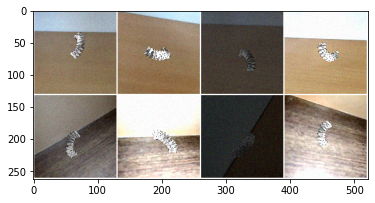

Output of network (To be verified with)


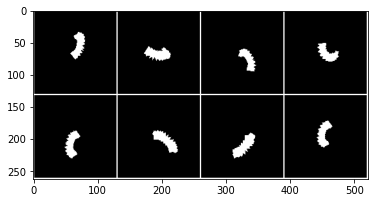

In [6]:
train_batch_size = 64
test_batch_size = 64
split_percent = 0.95

origami_dataset_dir = "/content/OrigamiDataset/Omega/omega"
random_background_dir = '/content/OrigamiDataset/BackgroundImages'
csv_dir = '/content/OrigamiDataset/Omega/omega_pose.csv'

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([Resize((128,128)),Normalize(), RandBrightness(),
                           AddNoise(0,0.001),ToTensor()])

origami = DataLoadResUnet(origami_dataset_dir,random_background_dir,
                                csv_dir, transform=trns)

train_size = int(split_percent * len(origami))
test_size = abs(len(origami) - train_size)
train_dataset, test_dataset = torch.utils.data.random_split(origami, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

test_loader = DataLoader(test_dataset, batch_size=test_batch_size,
                            shuffle=True,**kwargs)

print(f'Training dataset size: {len(train_dataset)} \
       Testing dataset size: {len(test_dataset)}')


iterator = iter(train_loader)
sample = iterator.next()

augmented,original, dof_vec = sample['augmented'],sample['original'], sample['dof_vec']

def imshow(img, images_show = 8):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}
    img = torchvision.utils.make_grid(img[:images_show,:], **kwargs)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

print('Input to network')
imshow(augmented)
print('Output of network (To be verified with)')
imshow(original)

### Model File

In [7]:
#defining the resunet model in pytorch

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True)
    )

def root_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
    )

# Define the ResNetUNet architecture
class ResNetUNet(nn.Module):

    def __init__(self, n_class=1):
        super().__init__()
        
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down11 = root_block(64, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down21 = root_block(128, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down31 = root_block(256, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down41 = root_block(512, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up31 = root_block(256, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up21 = root_block(128, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        self.dconv_up11 = root_block(64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

        self.onebyoneconv = nn.Conv2d(512,1,1)
        self.maxpool_lin = nn.MaxPool2d(4)
        # self.linear1 = nn.Linear(8192,1024)
        # self.linear2 = nn.Linear(1024, 6)
        self.linear1 = nn.Linear(256, 6)



    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.dconv_down11(conv1)
        x += conv1
        x = self.relu(x)
        x = self.maxpool(x)

        conv2 = self.dconv_down2(x)
        x = self.dconv_down21(conv2)
        x += conv2
        x = self.relu(x)
        x = self.maxpool(x)

        conv3 = self.dconv_down3(x)
        x = self.dconv_down31(conv3)
        x += conv3
        x = self.relu(x)
        x = self.maxpool(x)

        conv4 = self.dconv_down4(x)
        x = self.dconv_down41(conv4)
        x += conv4
        x = self.relu(x)        # op: [N, 512, 16, 16]

        ######### latent variable #########

        # latent = self.maxpool_lin(x)
        latent = self.onebyoneconv(x)
        flat = latent.reshape((int(latent.shape[0]),-1))
        y = self.linear1(flat)
        # y = self.relu(y)
        # y = self.linear2(y)
        # y = self.relu(y)

        dof = y
 
        ####################

        deconv3 = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        deconv3 = torch.cat([deconv3, conv3], dim=1)
        uconv3 = self.dconv_up3(deconv3)
        x = self.dconv_up31(uconv3)
        x += uconv3
        x = self.relu(x)

        deconv2 = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        deconv2 = torch.cat([deconv2, conv2], dim=1)
        uconv2 = self.dconv_up2(deconv2)
        x = self.dconv_up21(uconv2)
        x += uconv2
        x = self.relu(x)

        deconv1 = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        deconv1 = torch.cat([deconv1, conv1], dim=1)
        uconv1 = self.dconv_up1(deconv1)
        x = self.dconv_up11(uconv1)
        x += uconv1
        x = self.relu(x)

        out = self.conv_last(x)
        out = self.tanh(out)
        return out,dof

model = ResNetUNet()
model.forward(torch.randn(8,3,128,128))

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'learnable parameters: {params:,d}')

learnable parameters: 15,614,216


#  Binary Dice Loss



In [8]:
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

# Training Helper files

In [9]:
def train_nn_unet(model, device, train_loader, optimizer, loss_formula, epoch,log_interval=20):
    global store_train_loss
    model.train()
    l2 = nn.MSELoss()
    for batch_idx, sample in enumerate(train_loader):
        data, target, dof = sample['augmented'],sample['original'], sample['dof_vec']
        data, target, dof = data.to(device), target.to(device), dof.to(device)
        optimizer.zero_grad()
        reconst, dof_estimate = model(data)
        
        recons_loss = loss_formula(reconst, target)
        dof_loss = l2(dof, dof_estimate)
        loss = recons_loss + dof_loss
        loss.backward()
        
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tTotal Loss: {:.6f} \tRecons_loss Loss: {:.6f} \tdof_loss Loss: {:.6f}'.format(epoch,loss.item(),recons_loss.item(), dof_loss.item()))
    
    store_train_loss.append([epoch,loss.item()])


def test(model, device, test_loader,loss_formula,save_img=False,ep=None,save_folder=None):
    model.eval()
    global store_test_loss 
    test_loss, recons_loss, dof_loss = 0,0,0
    correct = 0
    l2 = nn.MSELoss()
    with torch.no_grad():
        for c, sample in enumerate(test_loader):
            data, target, dof = sample['augmented'],sample['original'], sample['dof_vec']
            data, target, dof = data.to(device), target.to(device), dof.to(device)
            reconst, dof_estimate = model(data)
            
            recons_loss += loss_formula(reconst, target)
            dof_loss += l2(dof, dof_estimate)
        
        test_loss = recons_loss + dof_loss

            # test_loss += loss_formula(reconst,target) + l2(dof, dof_estimate) # sum up batch loss
    test_loss /= max(1,c)
    recons_loss /= max(1,c)
    dof_loss /= max(1,c)

    print('\nTest set: Avg loss: {:.4f} Recons_loss \
    Loss: {:.6f}\tdof_loss Loss: {:.6f}'.format(test_loss,recons_loss, dof_loss))
    
    store_test_loss.append([ep,(test_loss).item()])
    
    if save_img:
        imshow_saver(data, reconst,os.path.join(save_folder,f'epoch_{ep}.png'),
                     images_show = 8)
        print('image saved')

def loss_plotter(store_train_loss, store_test_loss, epoch, location):
    store_train_loss= np.array(store_train_loss)
    store_test_loss= np.array(store_test_loss)
    plt.plot(store_train_loss[:,0], store_train_loss[:,1], label='Train Loss')
    plt.plot(store_test_loss[:,0], store_test_loss[:,1], label='Test Loss')
    plt.legend()
    plt.savefig(os.path.join(location,'plots',f'plot_{epoch}.png'))
    plt.show()

def imshow_saver(data, reconst,save_img_name, images_show = 8,viewer=True):
    '''
    Construct a grid for both reconstruction and input image values
    Also save them with filename save_img_name
    '''
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    img = torchvision.utils.make_grid(data[:images_show,:], **kwargs)
    npimg = img.cpu().numpy()
    data_np = np.transpose(npimg, (1, 2, 0))

    img = torchvision.utils.make_grid(reconst[:images_show,:], **kwargs)
    npimg = img.cpu().numpy()
    reconst_np = np.transpose(npimg, (1, 2, 0))

    cat = np.vstack((data_np,reconst_np))
    cat = np.clip(cat, 0, 1)
    plt.imsave(save_img_name, cat)
    if viewer:
        plt.imshow(cat)
        plt.show()

def google_drive_store(root, save_model_name, load_saved_model = True):
    '''
    Saves all model file, intermediate results and plots on drive location. 
    It will create folder as well. Make sure to mount drive before
    @param- saved_model_pth: save ur model with with this name 
            if already exsists, load these weights
    @param- load_saved_model: bool-Load saved model ?

    '''
    # root = '/content/drive/My Drive/RohitEeChianNUSTeleinternGamitrack/denoising_ae_colab/gs_haptic3'
    # save_model_name = "gs_haptic3.pt"

    ### Create folders if not exists
    saved_model_pth = os.path.join(os.path.join(root,save_model_name))
    if os.path.exists(saved_model_pth) and load_saved_model:
        model.load_state_dict(torch.load(saved_model_pth))
        print(f"[MODEL loaded] {saved_model_pth}")
   
    if not os.path.exists(root):
        os.mkdir(root)
        print(f'[Path Created] {root}')

    if not os.path.exists(os.path.join(root,'plots')):
        os.mkdir(os.path.join(root,'plots'))
        print(f'[Path Created] {os.path.join(root,'plots')}')
    
    val_img_save_folder = os.path.join(root,'validation_results')
    if not os.path.exists(val_img_save_folder):
        os.mkdir(val_img_save_folder)
        print(f'[Path Created] {val_img_save_folder}')

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Validate

In [11]:
class ToTensorValidate(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sample = np.transpose(sample, (2, 0, 1))
        return torch.from_numpy(sample)

class ResizeValidate(object):
    """ndarrays resize."""
    
    def __init__(self, size):
        self.size = size
        
    def __call__(self, sample):
        sample = cv2.resize(sample, dsize=self.size, interpolation=cv2.INTER_CUBIC)
        return sample

class NormalizeValidate(object):
    
    def __call__(self, sample):   
        
        min_noisy,max_noisy = np.min(sample),np.max(sample)
        sample = (sample - min_noisy)/(max_noisy-min_noisy)
        
        return sample

In [12]:
class ValidationGenerate(Dataset):

    def __init__(self, root_dir,transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.all_image_filenames = [f for f in os.listdir(self.root_dir) \
         if os.path.isfile(os.path.join(self.root_dir, f))]

    def __len__(self):
        return len(self.all_image_filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        inp_img_path = os.path.join(self.root_dir,
                                self.all_image_filenames[idx])
        
        sample = cv2.imread(inp_img_path)  
        sample = cv2.cvtColor(sample,cv2.COLOR_BGR2RGB)     
        if self.transform:
            sample = self.transform(sample)

        return sample,inp_img_path

def cross_validation(model, device, test_loader,ep = None, viewer=True, save_folder =None):
    model.eval()
    test_loss = 0
    correct = 0
    images_show = 8
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    with torch.no_grad():
        validator = iter(test_loader)
        sample,inp_img_path = next(validator)
        print(f'sample: {inp_img_path}')
        sample = sample.to(device).float()
        
        output, dof_estimate = model(sample)
        op = output[:images_show,:].cpu()
        tar = sample[:images_show,:].cpu()

    if viewer:
        print('Reconstructed')
        imshow(torchvision.utils.make_grid(op,**kwargs))
        print('Input to Netowrk')
        tar = sample[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(tar, **kwargs))  
    
    if save_folder is not None:
        imshow_saver(tar, op,'validation.png', images_show = 8,viewer=False)
    
    if save_folder is not None and ep is not None:
        imshow_saver(tar, op,os.path.join(save_folder, f'validation_{ep}.png'), 
                     images_show = 8,viewer=False)
        
    return sample, output, dof_estimate

def save_as_csv(arr, savefile):
    if os.path.exists(savefile):
        os.remove(savefile)
    arr = np.array(arr.cpu())
    for a in arr:
        print(a)
        rvec = a[3:]
        rot = cv2.Rodrigues(rvec)
        res = rot[0].reshape((1,9)).squeeze()
        
        r = f'{res[0]},{res[1]},{res[2]},{res[3]},{res[4]},{res[5]},{res[6]},{res[7]},{res[8]}'
        t = f'{a[0]},{a[1]},{a[2]},'
        stg = t + r + '\n'
        with open(savefile,'a') as f:
            f.write(stg)
    print('Files saved to be used in Rhino!')

In [13]:
def cross_validation(model, device, test_loader,ep = None, viewer=True, save_folder =None):
    model.eval()
    test_loss = 0
    correct = 0
    images_show = 8
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    with torch.no_grad():
        validator = iter(test_loader)
        sample,inp_img_path = next(validator)
        print(f'sample: {inp_img_path}')
        sample = sample.to(device).float()
        
        output, dof_estimate = model(sample)
        op = output[:images_show,:].cpu()
        tar = sample[:images_show,:].cpu()

    if viewer:
        print('Reconstructed')
        imshow(torchvision.utils.make_grid(op,**kwargs))
        print('Input to Netowrk')
        tar = sample[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(tar, **kwargs))  
    
    if save_folder is not None:
        imshow_saver(tar, op,'validation.png', images_show = 8,viewer=False)
    
    if save_folder is not None and ep is not None:
        imshow_saver(tar, op,os.path.join(save_folder, f'validation_{ep}.png'), 
                     images_show = 8,viewer=False)
        
    return sample, output, dof_estimate

In [14]:
## Loading and inferening model
origami_validate_dir = '/content/OrigamiDataset/Omega/omega_real'

root = '/content/drive/My Drive/ResUNET/exp7'
save_model_name = "savedModel.pt"

saved_model_pth = os.path.join(root,save_model_name)
google_drive_store(root,saved_model_pth, load_saved_model = True)




val_batch_size = 10
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([ResizeValidate((128,128)), NormalizeValidate(),ToTensorValidate() ])
validator = ValidationGenerate(root_dir=origami_validate_dir, transform=trns)
val_loader = DataLoader(validator, batch_size=val_batch_size,
                            shuffle=True,**kwargs)

model = ResNetUNet().to(device)

if not os.path.exists(saved_model_pth):
    print('saved file not found! Exitting..')
else:
    print('Model Loaded: Running Inference...')
    model.load_state_dict(torch.load(saved_model_pth))
    sample, output, dof_estimate = cross_validation(model, device, val_loader,
                                                save_folder = val_img_save_folder)

# save_as_csv(dof_estimate,'asds.csv')

[Path Created] : /content/drive/My Drive/ResUNET/exp7
[Path Created] :  /content/drive/My Drive/ResUNET/exp7/plots
[Path Created] : /content/drive/My Drive/ResUNET/exp7/validation_results
saved file not found! Exitting..


# Start Training Here

> The only variable u need to change is root. The code will create all folders for you :) 

- Intermediate **plots** are saved in `root/plots/plot_{epoch}.png`
- **Models weights** are saved in `root/save_model_name.pt`
- **Intermediate reconstructions** are saved at `root`

Remeber to delete old plots and saved results to avoid confusions between previously and recently trained



Train Epoch: 1 	Total Loss: 2.163247 	Recons_loss Loss: 0.905860 	dof_loss Loss: 1.257387
Train Epoch: 1 	Total Loss: 1.140198 	Recons_loss Loss: 0.531101 	dof_loss Loss: 0.609097
Train Epoch: 1 	Total Loss: 0.977903 	Recons_loss Loss: 0.533708 	dof_loss Loss: 0.444195
Train Epoch: 1 	Total Loss: 1.024455 	Recons_loss Loss: 0.513938 	dof_loss Loss: 0.510517
Train Epoch: 1 	Total Loss: 0.937887 	Recons_loss Loss: 0.513533 	dof_loss Loss: 0.424355

Test set: Avg loss: 0.8912 Recons_loss     Loss: 0.541954	dof_loss Loss: 0.349270


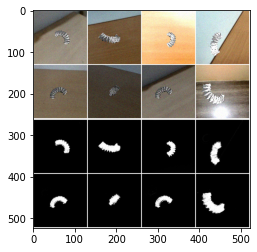

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_1107.png', '/content/OrigamiDataset/Omega/omega_real/im_1142.png', '/content/OrigamiDataset/Omega/omega_real/im_537.png', '/content/OrigamiDataset/Omega/omega_real/im_1328.png', '/content/OrigamiDataset/Omega/omega_real/im_165.png', '/content/OrigamiDataset/Omega/omega_real/im_753.png', '/content/OrigamiDataset/Omega/omega_real/im_891.png', '/content/OrigamiDataset/Omega/omega_real/im_1528.png', '/content/OrigamiDataset/Omega/omega_real/im_921.png', '/content/OrigamiDataset/Omega/omega_real/im_904.png']
Reconstructed


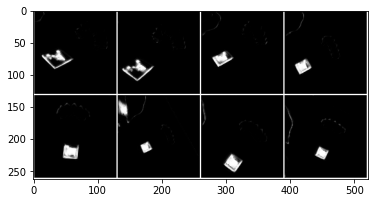

Input to Netowrk


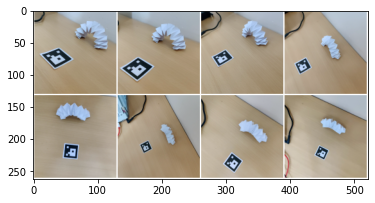

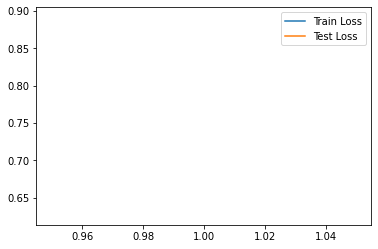

Model and Loss Saved!


Train Epoch: 2 	Total Loss: 0.724299 	Recons_loss Loss: 0.513230 	dof_loss Loss: 0.211069
Train Epoch: 2 	Total Loss: 0.677165 	Recons_loss Loss: 0.511981 	dof_loss Loss: 0.165183
Train Epoch: 2 	Total Loss: 0.641133 	Recons_loss Loss: 0.509377 	dof_loss Loss: 0.131756
Train Epoch: 2 	Total Loss: 0.710516 	Recons_loss Loss: 0.508914 	dof_loss Loss: 0.201602
Train Epoch: 2 	Total Loss: 0.762380 	Recons_loss Loss: 0.507997 	dof_loss Loss: 0.254384

Test set: Avg loss: 0.7215 Recons_loss     Loss: 0.530297	dof_loss Loss: 0.191156


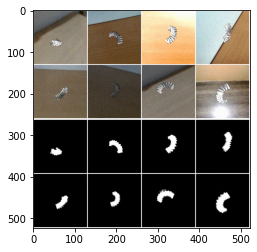

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_30.png', '/content/OrigamiDataset/Omega/omega_real/im_487.png', '/content/OrigamiDataset/Omega/omega_real/im_1274.png', '/content/OrigamiDataset/Omega/omega_real/im_1223.png', '/content/OrigamiDataset/Omega/omega_real/im_769.png', '/content/OrigamiDataset/Omega/omega_real/im_566.png', '/content/OrigamiDataset/Omega/omega_real/im_178.png', '/content/OrigamiDataset/Omega/omega_real/im_1246.png', '/content/OrigamiDataset/Omega/omega_real/im_330.png', '/content/OrigamiDataset/Omega/omega_real/im_1080.png']
Reconstructed


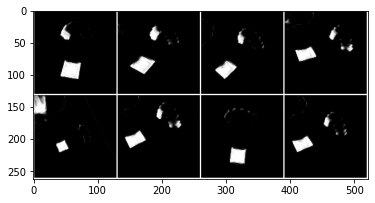

Input to Netowrk


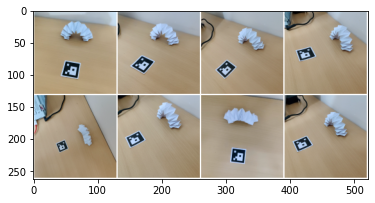

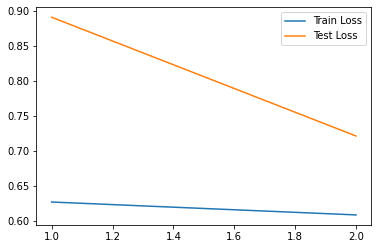

Model and Loss Saved!


Train Epoch: 3 	Total Loss: 0.679972 	Recons_loss Loss: 0.507690 	dof_loss Loss: 0.172281
Train Epoch: 3 	Total Loss: 0.712819 	Recons_loss Loss: 0.509602 	dof_loss Loss: 0.203217
Train Epoch: 3 	Total Loss: 0.766545 	Recons_loss Loss: 0.507941 	dof_loss Loss: 0.258604
Train Epoch: 3 	Total Loss: 0.672044 	Recons_loss Loss: 0.505603 	dof_loss Loss: 0.166441
Train Epoch: 3 	Total Loss: 0.771518 	Recons_loss Loss: 0.506481 	dof_loss Loss: 0.265037

Test set: Avg loss: 0.7652 Recons_loss     Loss: 0.531122	dof_loss Loss: 0.234043


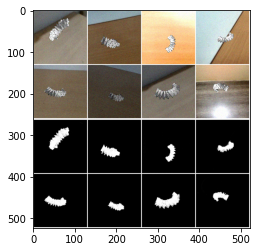

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_1034.png', '/content/OrigamiDataset/Omega/omega_real/im_345.png', '/content/OrigamiDataset/Omega/omega_real/im_1202.png', '/content/OrigamiDataset/Omega/omega_real/im_750.png', '/content/OrigamiDataset/Omega/omega_real/im_1589.png', '/content/OrigamiDataset/Omega/omega_real/im_917.png', '/content/OrigamiDataset/Omega/omega_real/im_826.png', '/content/OrigamiDataset/Omega/omega_real/im_393.png', '/content/OrigamiDataset/Omega/omega_real/im_670.png', '/content/OrigamiDataset/Omega/omega_real/im_184.png']
Reconstructed


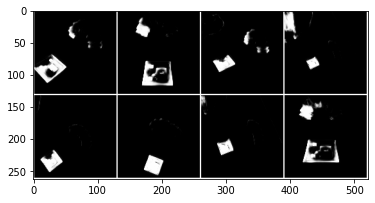

Input to Netowrk


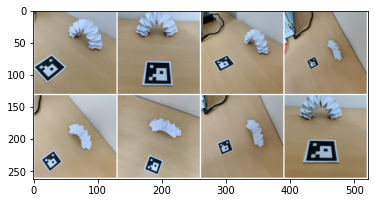

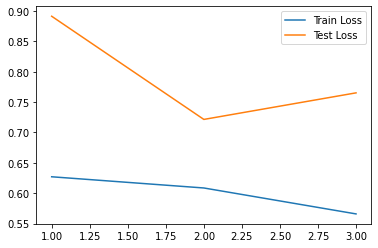

Model and Loss Saved!


Train Epoch: 4 	Total Loss: 0.678495 	Recons_loss Loss: 0.506310 	dof_loss Loss: 0.172184
Train Epoch: 4 	Total Loss: 0.668258 	Recons_loss Loss: 0.504816 	dof_loss Loss: 0.163443
Train Epoch: 4 	Total Loss: 0.813121 	Recons_loss Loss: 0.506379 	dof_loss Loss: 0.306742
Train Epoch: 4 	Total Loss: 0.581280 	Recons_loss Loss: 0.505183 	dof_loss Loss: 0.076097
Train Epoch: 4 	Total Loss: 0.754190 	Recons_loss Loss: 0.505724 	dof_loss Loss: 0.248466

Test set: Avg loss: 0.6886 Recons_loss     Loss: 0.527936	dof_loss Loss: 0.160680


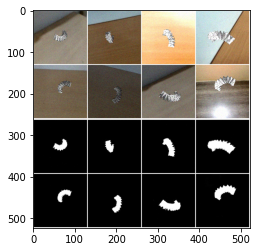

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_834.png', '/content/OrigamiDataset/Omega/omega_real/im_1055.png', '/content/OrigamiDataset/Omega/omega_real/im_979.png', '/content/OrigamiDataset/Omega/omega_real/im_617.png', '/content/OrigamiDataset/Omega/omega_real/im_299.png', '/content/OrigamiDataset/Omega/omega_real/im_442.png', '/content/OrigamiDataset/Omega/omega_real/im_1562.png', '/content/OrigamiDataset/Omega/omega_real/im_1121.png', '/content/OrigamiDataset/Omega/omega_real/im_1597.png', '/content/OrigamiDataset/Omega/omega_real/im_435.png']
Reconstructed


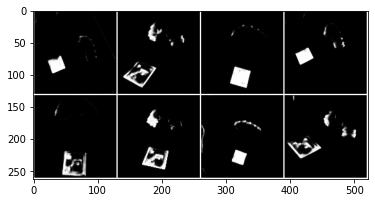

Input to Netowrk


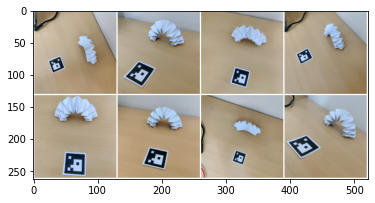

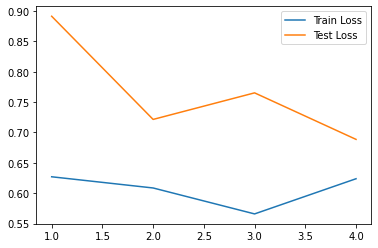

Model and Loss Saved!


Train Epoch: 5 	Total Loss: 0.556844 	Recons_loss Loss: 0.505587 	dof_loss Loss: 0.051257
Train Epoch: 5 	Total Loss: 0.641372 	Recons_loss Loss: 0.504395 	dof_loss Loss: 0.136977
Train Epoch: 5 	Total Loss: 0.550987 	Recons_loss Loss: 0.505423 	dof_loss Loss: 0.045564
Train Epoch: 5 	Total Loss: 0.592165 	Recons_loss Loss: 0.504257 	dof_loss Loss: 0.087908
Train Epoch: 5 	Total Loss: 0.697406 	Recons_loss Loss: 0.505842 	dof_loss Loss: 0.191564

Test set: Avg loss: 0.6671 Recons_loss     Loss: 0.526968	dof_loss Loss: 0.140172


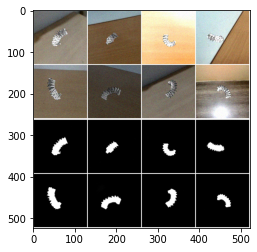

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_997.png', '/content/OrigamiDataset/Omega/omega_real/im_1343.png', '/content/OrigamiDataset/Omega/omega_real/im_262.png', '/content/OrigamiDataset/Omega/omega_real/im_1285.png', '/content/OrigamiDataset/Omega/omega_real/im_959.png', '/content/OrigamiDataset/Omega/omega_real/im_1611.png', '/content/OrigamiDataset/Omega/omega_real/im_1133.png', '/content/OrigamiDataset/Omega/omega_real/im_285.png', '/content/OrigamiDataset/Omega/omega_real/im_687.png', '/content/OrigamiDataset/Omega/omega_real/im_941.png']
Reconstructed


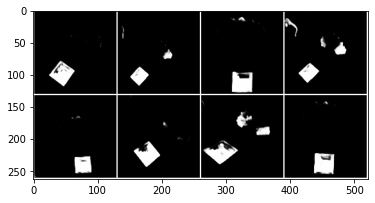

Input to Netowrk


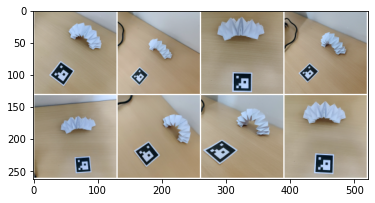

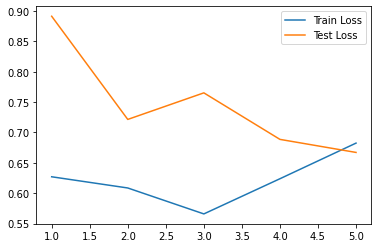

Model and Loss Saved!


Train Epoch: 6 	Total Loss: 0.682472 	Recons_loss Loss: 0.504789 	dof_loss Loss: 0.177683
Train Epoch: 6 	Total Loss: 0.589653 	Recons_loss Loss: 0.504305 	dof_loss Loss: 0.085348
Train Epoch: 6 	Total Loss: 0.557433 	Recons_loss Loss: 0.505501 	dof_loss Loss: 0.051932
Train Epoch: 6 	Total Loss: 0.582562 	Recons_loss Loss: 0.504040 	dof_loss Loss: 0.078522
Train Epoch: 6 	Total Loss: 0.730686 	Recons_loss Loss: 0.504023 	dof_loss Loss: 0.226663

Test set: Avg loss: 0.6373 Recons_loss     Loss: 0.526526	dof_loss Loss: 0.110816


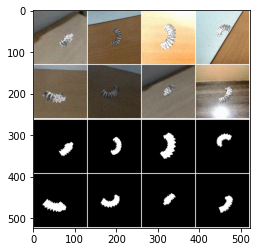

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_262.png', '/content/OrigamiDataset/Omega/omega_real/im_1178.png', '/content/OrigamiDataset/Omega/omega_real/im_1013.png', '/content/OrigamiDataset/Omega/omega_real/im_1130.png', '/content/OrigamiDataset/Omega/omega_real/im_1488.png', '/content/OrigamiDataset/Omega/omega_real/im_1368.png', '/content/OrigamiDataset/Omega/omega_real/im_1365.png', '/content/OrigamiDataset/Omega/omega_real/im_649.png', '/content/OrigamiDataset/Omega/omega_real/im_677.png', '/content/OrigamiDataset/Omega/omega_real/im_1396.png']
Reconstructed


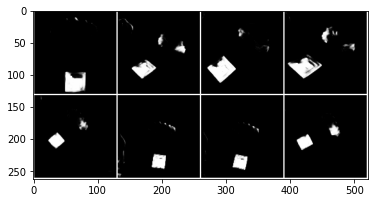

Input to Netowrk


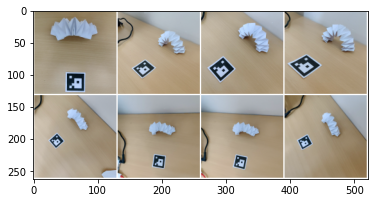

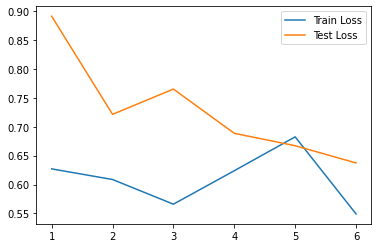

Model and Loss Saved!


Train Epoch: 7 	Total Loss: 0.563451 	Recons_loss Loss: 0.504448 	dof_loss Loss: 0.059003
Train Epoch: 7 	Total Loss: 0.628443 	Recons_loss Loss: 0.503813 	dof_loss Loss: 0.124630
Train Epoch: 7 	Total Loss: 0.601474 	Recons_loss Loss: 0.504613 	dof_loss Loss: 0.096861
Train Epoch: 7 	Total Loss: 0.538850 	Recons_loss Loss: 0.503637 	dof_loss Loss: 0.035213
Train Epoch: 7 	Total Loss: 0.662071 	Recons_loss Loss: 0.503831 	dof_loss Loss: 0.158240

Test set: Avg loss: 0.6434 Recons_loss     Loss: 0.525907	dof_loss Loss: 0.117460


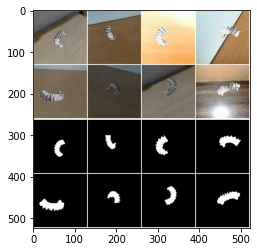

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_1235.png', '/content/OrigamiDataset/Omega/omega_real/im_868.png', '/content/OrigamiDataset/Omega/omega_real/im_1629.png', '/content/OrigamiDataset/Omega/omega_real/im_1109.png', '/content/OrigamiDataset/Omega/omega_real/im_1618.png', '/content/OrigamiDataset/Omega/omega_real/im_1406.png', '/content/OrigamiDataset/Omega/omega_real/im_864.png', '/content/OrigamiDataset/Omega/omega_real/im_438.png', '/content/OrigamiDataset/Omega/omega_real/im_159.png', '/content/OrigamiDataset/Omega/omega_real/im_78.png']
Reconstructed


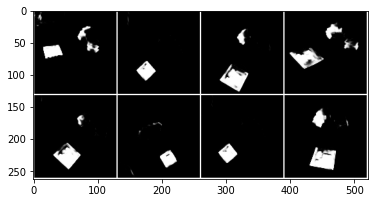

Input to Netowrk


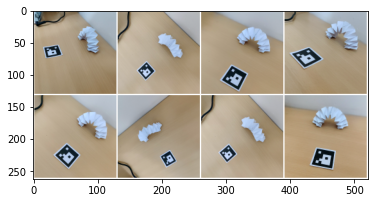

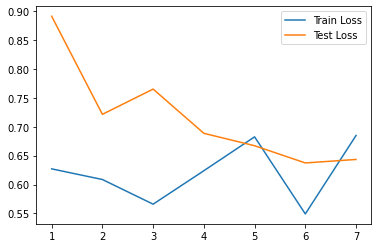

Model and Loss Saved!


Train Epoch: 8 	Total Loss: 0.685367 	Recons_loss Loss: 0.504368 	dof_loss Loss: 0.180998
Train Epoch: 8 	Total Loss: 0.705792 	Recons_loss Loss: 0.503575 	dof_loss Loss: 0.202217
Train Epoch: 8 	Total Loss: 0.563154 	Recons_loss Loss: 0.503811 	dof_loss Loss: 0.059343
Train Epoch: 8 	Total Loss: 0.560897 	Recons_loss Loss: 0.503356 	dof_loss Loss: 0.057541
Train Epoch: 8 	Total Loss: 0.565105 	Recons_loss Loss: 0.503571 	dof_loss Loss: 0.061535

Test set: Avg loss: 0.6363 Recons_loss     Loss: 0.526011	dof_loss Loss: 0.110308


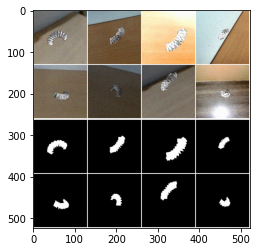

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_509.png', '/content/OrigamiDataset/Omega/omega_real/im_893.png', '/content/OrigamiDataset/Omega/omega_real/im_1403.png', '/content/OrigamiDataset/Omega/omega_real/im_1038.png', '/content/OrigamiDataset/Omega/omega_real/im_1371.png', '/content/OrigamiDataset/Omega/omega_real/im_1444.png', '/content/OrigamiDataset/Omega/omega_real/im_770.png', '/content/OrigamiDataset/Omega/omega_real/im_1080.png', '/content/OrigamiDataset/Omega/omega_real/im_367.png', '/content/OrigamiDataset/Omega/omega_real/im_581.png']
Reconstructed


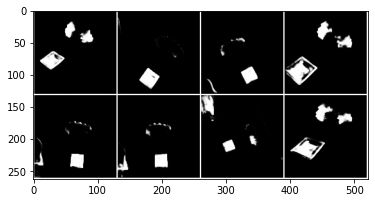

Input to Netowrk


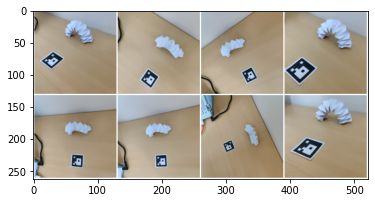

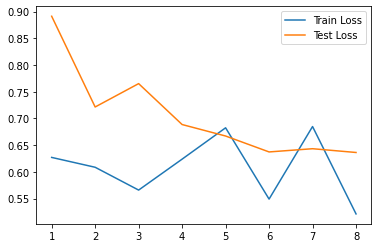

Model and Loss Saved!


Train Epoch: 9 	Total Loss: 0.558707 	Recons_loss Loss: 0.504423 	dof_loss Loss: 0.054283
Train Epoch: 9 	Total Loss: 0.559772 	Recons_loss Loss: 0.503567 	dof_loss Loss: 0.056206
Train Epoch: 9 	Total Loss: 0.615970 	Recons_loss Loss: 0.503570 	dof_loss Loss: 0.112400
Train Epoch: 9 	Total Loss: 0.529131 	Recons_loss Loss: 0.502916 	dof_loss Loss: 0.026216
Train Epoch: 9 	Total Loss: 0.792747 	Recons_loss Loss: 0.503075 	dof_loss Loss: 0.289673

Test set: Avg loss: 0.6670 Recons_loss     Loss: 0.525559	dof_loss Loss: 0.141450


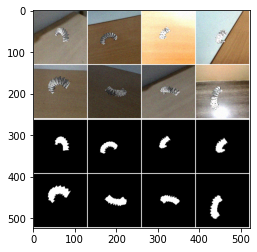

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_1148.png', '/content/OrigamiDataset/Omega/omega_real/im_1400.png', '/content/OrigamiDataset/Omega/omega_real/im_123.png', '/content/OrigamiDataset/Omega/omega_real/im_1574.png', '/content/OrigamiDataset/Omega/omega_real/im_865.png', '/content/OrigamiDataset/Omega/omega_real/im_1370.png', '/content/OrigamiDataset/Omega/omega_real/im_702.png', '/content/OrigamiDataset/Omega/omega_real/im_1354.png', '/content/OrigamiDataset/Omega/omega_real/im_594.png', '/content/OrigamiDataset/Omega/omega_real/im_1153.png']
Reconstructed


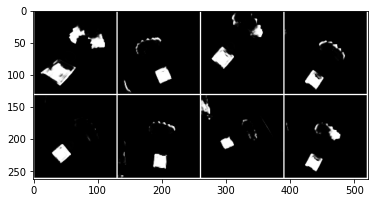

Input to Netowrk


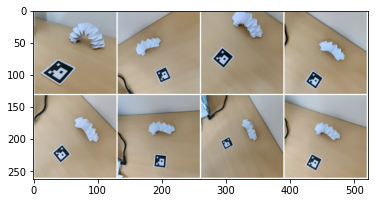

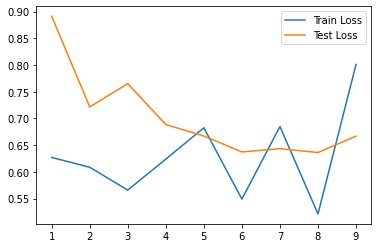

Model and Loss Saved!


Train Epoch: 10 	Total Loss: 0.544732 	Recons_loss Loss: 0.503412 	dof_loss Loss: 0.041320
Train Epoch: 10 	Total Loss: 0.671804 	Recons_loss Loss: 0.503176 	dof_loss Loss: 0.168628
Train Epoch: 10 	Total Loss: 0.545963 	Recons_loss Loss: 0.503611 	dof_loss Loss: 0.042351
Train Epoch: 10 	Total Loss: 0.616885 	Recons_loss Loss: 0.502996 	dof_loss Loss: 0.113889
Train Epoch: 10 	Total Loss: 0.551234 	Recons_loss Loss: 0.504542 	dof_loss Loss: 0.046692

Test set: Avg loss: 0.6474 Recons_loss     Loss: 0.525575	dof_loss Loss: 0.121804


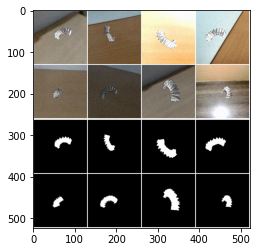

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_568.png', '/content/OrigamiDataset/Omega/omega_real/im_1062.png', '/content/OrigamiDataset/Omega/omega_real/im_186.png', '/content/OrigamiDataset/Omega/omega_real/im_1353.png', '/content/OrigamiDataset/Omega/omega_real/im_1527.png', '/content/OrigamiDataset/Omega/omega_real/im_9.png', '/content/OrigamiDataset/Omega/omega_real/im_1506.png', '/content/OrigamiDataset/Omega/omega_real/im_770.png', '/content/OrigamiDataset/Omega/omega_real/im_234.png', '/content/OrigamiDataset/Omega/omega_real/im_949.png']
Reconstructed


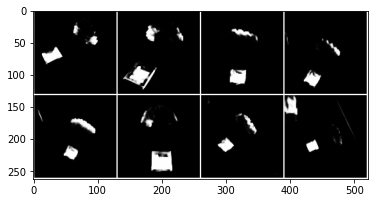

Input to Netowrk


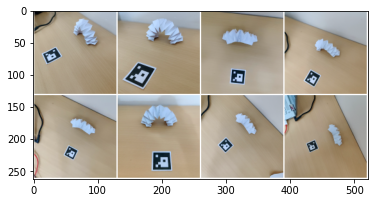

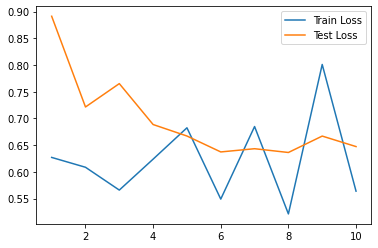

Model and Loss Saved!


Train Epoch: 11 	Total Loss: 0.575112 	Recons_loss Loss: 0.503329 	dof_loss Loss: 0.071783
Train Epoch: 11 	Total Loss: 0.530033 	Recons_loss Loss: 0.502796 	dof_loss Loss: 0.027237
Train Epoch: 11 	Total Loss: 0.534227 	Recons_loss Loss: 0.503279 	dof_loss Loss: 0.030948
Train Epoch: 11 	Total Loss: 0.541301 	Recons_loss Loss: 0.502803 	dof_loss Loss: 0.038498
Train Epoch: 11 	Total Loss: 0.522988 	Recons_loss Loss: 0.503235 	dof_loss Loss: 0.019753

Test set: Avg loss: 0.6810 Recons_loss     Loss: 0.525095	dof_loss Loss: 0.155947


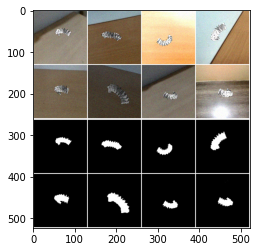

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_1361.png', '/content/OrigamiDataset/Omega/omega_real/im_578.png', '/content/OrigamiDataset/Omega/omega_real/im_1186.png', '/content/OrigamiDataset/Omega/omega_real/im_1360.png', '/content/OrigamiDataset/Omega/omega_real/im_270.png', '/content/OrigamiDataset/Omega/omega_real/im_752.png', '/content/OrigamiDataset/Omega/omega_real/im_994.png', '/content/OrigamiDataset/Omega/omega_real/im_22.png', '/content/OrigamiDataset/Omega/omega_real/im_351.png', '/content/OrigamiDataset/Omega/omega_real/im_455.png']
Reconstructed


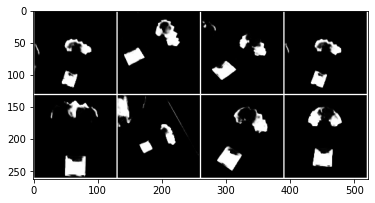

Input to Netowrk


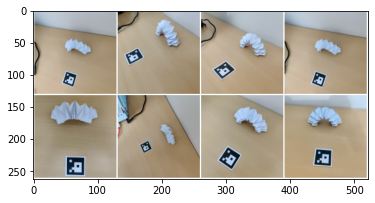

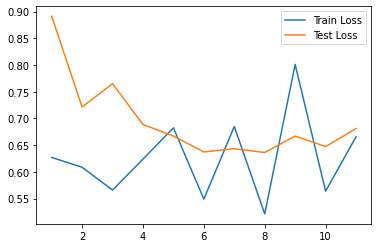

Model and Loss Saved!


Train Epoch: 12 	Total Loss: 0.594700 	Recons_loss Loss: 0.503122 	dof_loss Loss: 0.091578
Train Epoch: 12 	Total Loss: 0.558506 	Recons_loss Loss: 0.502681 	dof_loss Loss: 0.055825
Train Epoch: 12 	Total Loss: 0.603177 	Recons_loss Loss: 0.503204 	dof_loss Loss: 0.099973
Train Epoch: 12 	Total Loss: 0.523820 	Recons_loss Loss: 0.502485 	dof_loss Loss: 0.021335
Train Epoch: 12 	Total Loss: 0.534745 	Recons_loss Loss: 0.502826 	dof_loss Loss: 0.031919

Test set: Avg loss: 0.6356 Recons_loss     Loss: 0.524828	dof_loss Loss: 0.110728


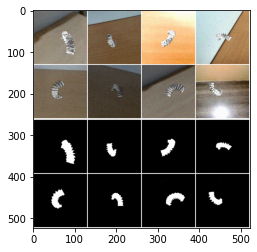

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_639.png', '/content/OrigamiDataset/Omega/omega_real/im_1331.png', '/content/OrigamiDataset/Omega/omega_real/im_820.png', '/content/OrigamiDataset/Omega/omega_real/im_486.png', '/content/OrigamiDataset/Omega/omega_real/im_210.png', '/content/OrigamiDataset/Omega/omega_real/im_118.png', '/content/OrigamiDataset/Omega/omega_real/im_110.png', '/content/OrigamiDataset/Omega/omega_real/im_449.png', '/content/OrigamiDataset/Omega/omega_real/im_357.png', '/content/OrigamiDataset/Omega/omega_real/im_991.png']
Reconstructed


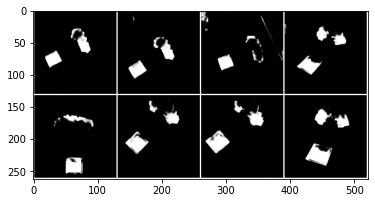

Input to Netowrk


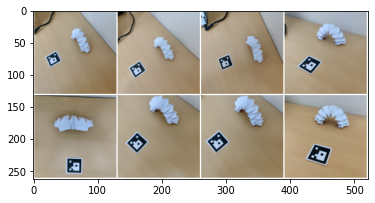

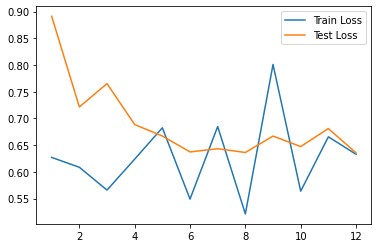

Model and Loss Saved!


Train Epoch: 13 	Total Loss: 0.528133 	Recons_loss Loss: 0.503018 	dof_loss Loss: 0.025114
Train Epoch: 13 	Total Loss: 0.575041 	Recons_loss Loss: 0.502743 	dof_loss Loss: 0.072298
Train Epoch: 13 	Total Loss: 0.537133 	Recons_loss Loss: 0.503207 	dof_loss Loss: 0.033926
Train Epoch: 13 	Total Loss: 0.617248 	Recons_loss Loss: 0.502617 	dof_loss Loss: 0.114631
Train Epoch: 13 	Total Loss: 0.515738 	Recons_loss Loss: 0.503024 	dof_loss Loss: 0.012714

Test set: Avg loss: 0.5919 Recons_loss     Loss: 0.524750	dof_loss Loss: 0.067143


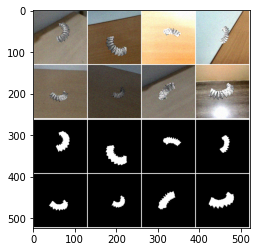

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_436.png', '/content/OrigamiDataset/Omega/omega_real/im_39.png', '/content/OrigamiDataset/Omega/omega_real/im_1162.png', '/content/OrigamiDataset/Omega/omega_real/im_84.png', '/content/OrigamiDataset/Omega/omega_real/im_1468.png', '/content/OrigamiDataset/Omega/omega_real/im_605.png', '/content/OrigamiDataset/Omega/omega_real/im_745.png', '/content/OrigamiDataset/Omega/omega_real/im_874.png', '/content/OrigamiDataset/Omega/omega_real/im_811.png', '/content/OrigamiDataset/Omega/omega_real/im_123.png']
Reconstructed


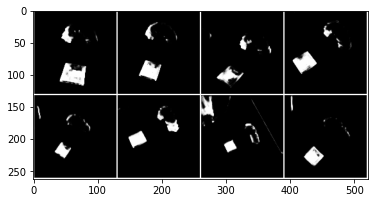

Input to Netowrk


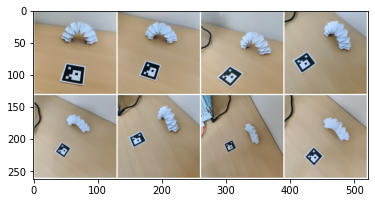

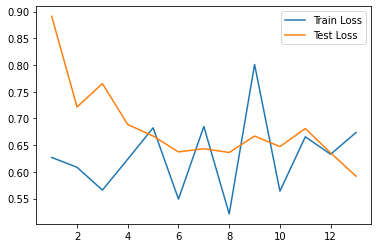

Model and Loss Saved!


Train Epoch: 14 	Total Loss: 0.519563 	Recons_loss Loss: 0.502780 	dof_loss Loss: 0.016783
Train Epoch: 14 	Total Loss: 0.521062 	Recons_loss Loss: 0.502328 	dof_loss Loss: 0.018734
Train Epoch: 14 	Total Loss: 0.564859 	Recons_loss Loss: 0.502806 	dof_loss Loss: 0.062053
Train Epoch: 14 	Total Loss: 0.557503 	Recons_loss Loss: 0.502480 	dof_loss Loss: 0.055024
Train Epoch: 14 	Total Loss: 0.541573 	Recons_loss Loss: 0.502480 	dof_loss Loss: 0.039093

Test set: Avg loss: 0.6089 Recons_loss     Loss: 0.524571	dof_loss Loss: 0.084307


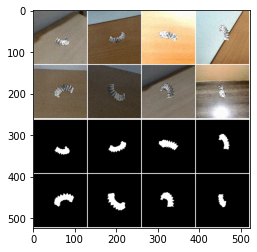

image saved
Test on original dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample: ['/content/OrigamiDataset/Omega/omega_real/im_761.png', '/content/OrigamiDataset/Omega/omega_real/im_1423.png', '/content/OrigamiDataset/Omega/omega_real/im_1189.png', '/content/OrigamiDataset/Omega/omega_real/im_297.png', '/content/OrigamiDataset/Omega/omega_real/im_500.png', '/content/OrigamiDataset/Omega/omega_real/im_1512.png', '/content/OrigamiDataset/Omega/omega_real/im_179.png', '/content/OrigamiDataset/Omega/omega_real/im_57.png', '/content/OrigamiDataset/Omega/omega_real/im_1621.png', '/content/OrigamiDataset/Omega/omega_real/im_1194.png']
Reconstructed


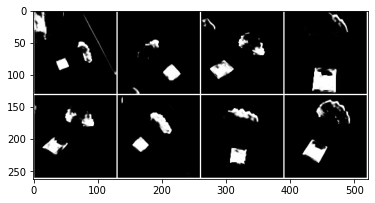

Input to Netowrk


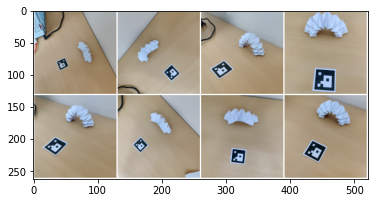

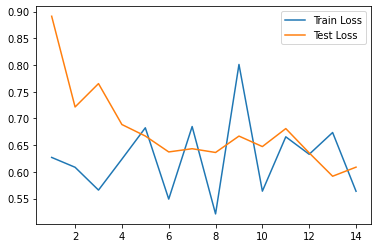

Model and Loss Saved!


Train Epoch: 15 	Total Loss: 0.603335 	Recons_loss Loss: 0.502946 	dof_loss Loss: 0.100389
Train Epoch: 15 	Total Loss: 0.551647 	Recons_loss Loss: 0.502185 	dof_loss Loss: 0.049462
Train Epoch: 15 	Total Loss: 0.598093 	Recons_loss Loss: 0.502749 	dof_loss Loss: 0.095344
Train Epoch: 15 	Total Loss: 0.556641 	Recons_loss Loss: 0.502231 	dof_loss Loss: 0.054410


In [ ]:
epochs = 10000
save_model_and_losses = True

save_after = 1 #epocs (saves model and graphs)
model = ResNetUNet().to(device)
saved_model_pth = 'savedModel.pt'
root = '/content/drive/My Drive/ResUNET/exp7'
origami_validate_dir = '/content/OrigamiDataset/Omega'

google_drive_store(root,saved_model_pth, 
                   load_saved_model = True)

### Start training here

optimizer = optim.Adam(model.parameters(), lr=0.0005)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.7)
dice_loss = BinaryDiceLoss()
store_train_loss = []
store_test_loss = []

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    
    train_nn_unet(model, device, train_loader, optimizer, dice_loss, epoch,log_interval=100)
    
    if epoch % save_after ==0:
        test(model, device, test_loader,dice_loss,
             save_img=True, ep = epoch, save_folder=root)
        
        print('Test on original dataset')
        sample, output, dof_estimate = cross_validation(model, 
                                            device, val_loader, ep=epoch, 
                                           save_folder = os.path.join(root,'validation_results'))
        
        if save_model_and_losses:
            torch.save(model.state_dict(), os.path.join(root,saved_model_pth))
            
            np.save(os.path.join(root,'plots','train_losss.npy')
                        , store_train_loss)
            
            np.save(os.path.join(root,'plots','test_losss.npy')
                        , store_test_loss)
            
            loss_plotter(store_train_loss, store_test_loss,epoch,root)
            print('Model and Loss Saved!')
    print('\n')